In [1]:
import os

while '.gitignore' not in os.listdir():
    os.chdir('..')

import jax.numpy as jnp
import functools
import jax
from jax.scipy.signal import convolve2d
from jax.scipy import signal
import matplotlib.pyplot as plt
import cv2
import numpy as np

from src import img_utils

(775, 1024)

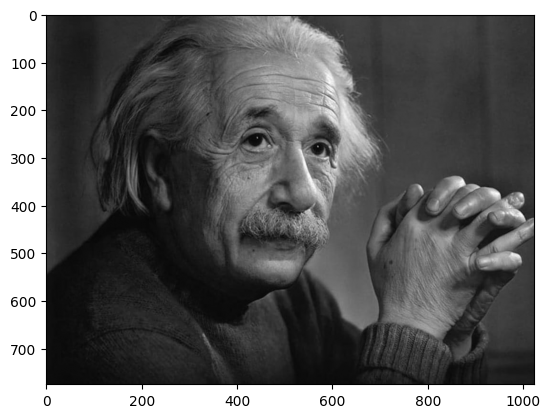

In [2]:
image = cv2.imread('data/einstein.jpg')
image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
image = image.mean(axis=2)
plt.imshow(image, cmap='gray')
image.shape

# Creating the directional gradients for an image

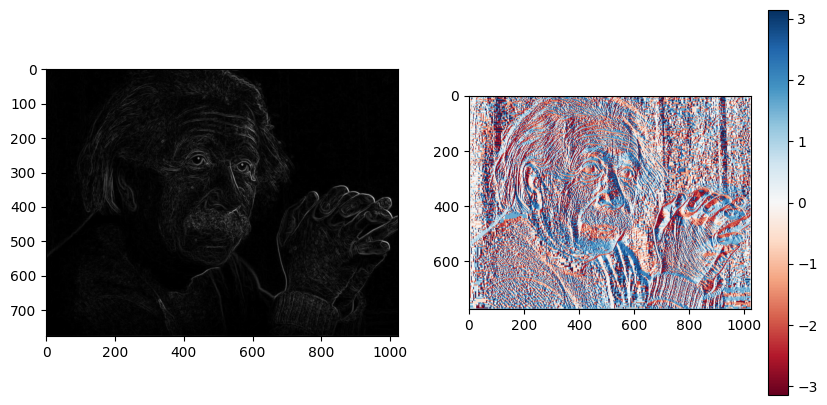

In [3]:
f_x, f_y    = img_utils.first_derivatives( image )
gradient    = jnp.sqrt( f_x**2 + f_y**2 )
orientation = jnp.atan2( f_y, f_x )


_, (ax1, ax2) = plt.subplots(1, 2, figsize = (10, 5))
ax1.imshow( gradient,    cmap='gray' )
im = ax2.imshow( orientation, cmap='RdBu' )
plt.colorbar(im)

In [4]:
grad_flat   = gradient.flatten()
orient_flat = orientation.flatten()

index_orient = jnp.digitize( orient_flat, jnp.linspace(-jnp.pi, jnp.pi, 100) )

In [5]:
index_orient

Array([13, 22, 26, ..., 75, 72, 63], dtype=int32)

<BarContainer object of 100 artists>

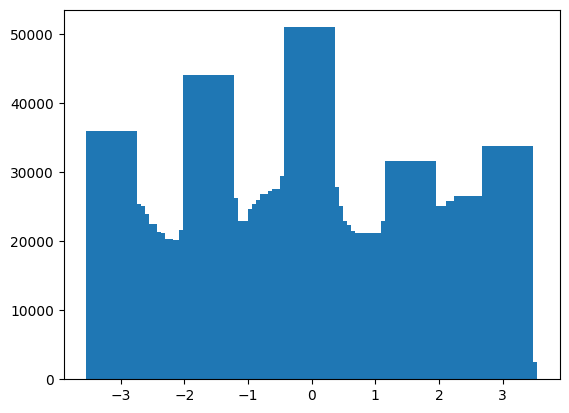

In [6]:
hog = jnp.array([grad_flat[ index_orient == (i+1) ].sum() for i in range(100)])
plt.bar(jnp.linspace(-jnp.pi, jnp.pi, 100), hog)

In [7]:
orient_flat[index_orient == 5]

Array([-2.882833 , -2.8554208, -2.8429186, ..., -2.8519144, -2.8707533,
       -2.8342054], dtype=float32)

# Create a 2D HOG representation

This current picture is a 775x1024 image. We will digitize in the $x$-axis by 32 and the $y$ axis by 25, resulting in a (32,31) grid. 

Note, this still needs to be completed

In [9]:
gradient.shape, orientation.shape

((775, 1024), (775, 1024))

In [93]:
775/5, 1024/16

(155.0, 64.0)

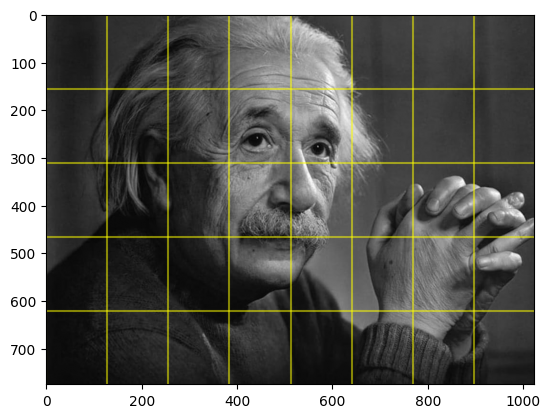

In [97]:
plt.imshow(image, cmap='grey')
Nx, Ny = 8, 5
Sy, Sx = image.shape
dy, dx = Sy//Ny, Sx//Nx
for x in range(Nx):
    plt.axvline( x*dx, color='yellow' , alpha=0.5)
for y in range(Ny):
    plt.axhline( y*dy, color='yellow', alpha=0.5 )
plt.savefig('results/hog_2D.png', dpi=300)

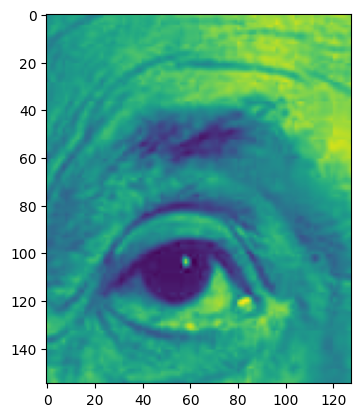

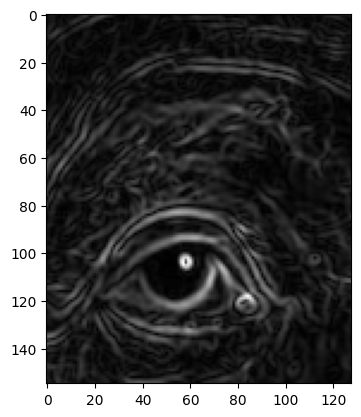

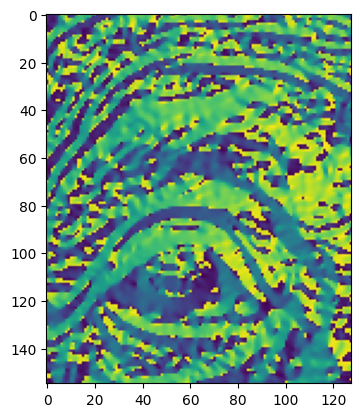

In [101]:
x, y = 3, 1

plt.figure()
image_s = image[ y*dy:(y+1)*dy , x*dx:(x+1)*dx  ]
plt.imshow(image_s)

plt.figure()
gradient_s = gradient[ y*dy:(y+1)*dy , x*dx:(x+1)*dx  ]
plt.imshow(gradient_s, cmap='grey')

plt.figure()
orientation_s = orientation[ y*dy:(y+1)*dy , x*dx:(x+1)*dx  ]
plt.imshow(orientation_s)

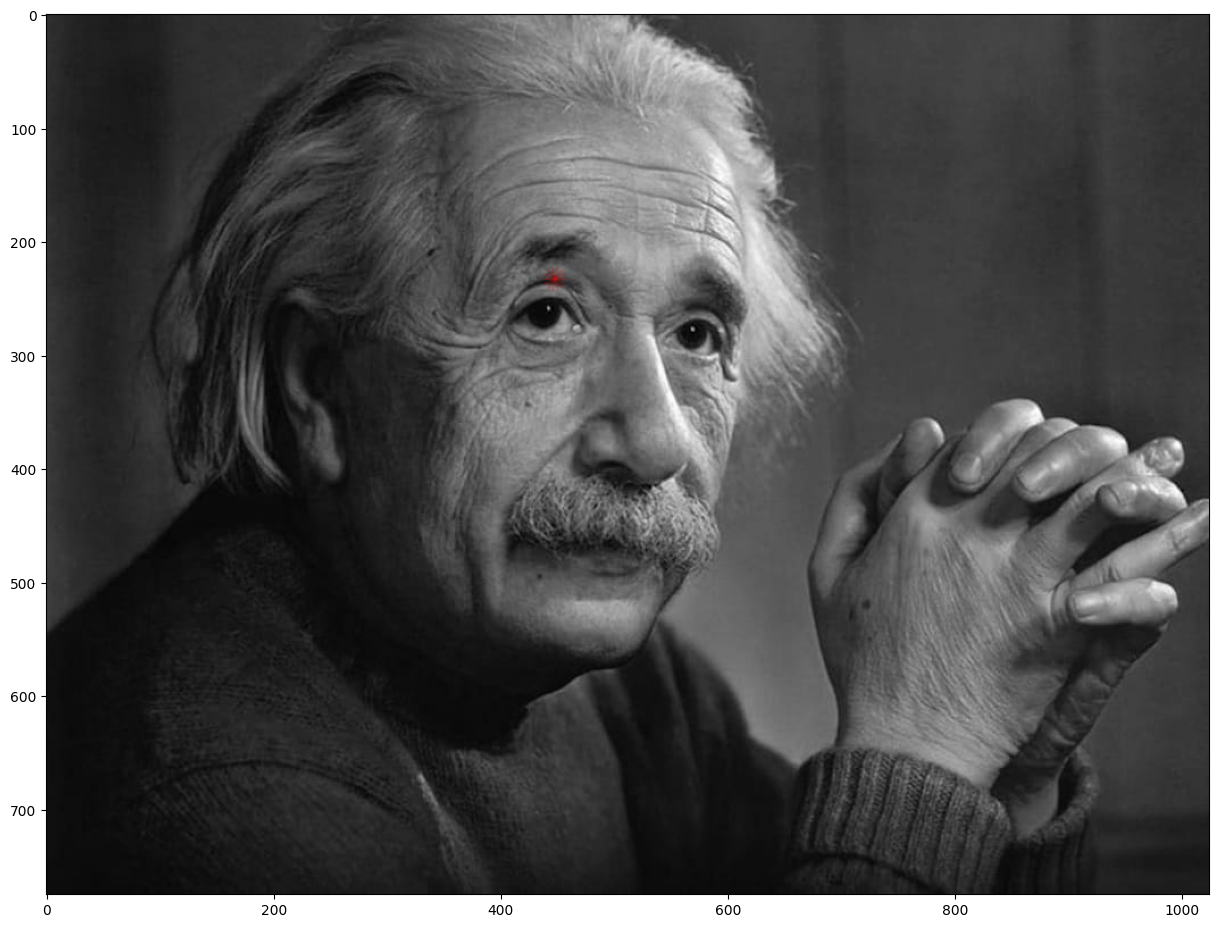

In [102]:
plt.figure(figsize=(15, 15))
plt.imshow( image, cmap='grey' )

x, y = 3, 1
Nangle = 8

bins = jnp.linspace( -jnp.pi, jnp.pi, Nangle )
cx, cy = (x+0.5)*dx, (y+0.5)*dy

image_s       = image[ y*dy:(y+1)*dy , x*dx:(x+1)*dx  ]
gradient_s    = gradient[ y*dy:(y+1)*dy , x*dx:(x+1)*dx  ]
orientation_s = orientation[ y*dy:(y+1)*dy , x*dx:(x+1)*dx  ]

ds = jnp.digitize( orientation_s.flatten(), bins=bins )

temp = jnp.zeros(Nangle)
for d, g in zip(ds, gradient_s.flatten()):
    temp = temp.at[d].add(g)

temp = jnp.log1p(temp)

for bin, t in zip(bins, temp):
    x1, y1 = t*jnp.cos(bin), t*jnp.sin(bin)
    plt.plot([-x1+cx, x1+cx], [-y1+cy, y1+cy], alpha=0.2, color='r')